In [65]:
# !pip install --upgrade pip

import os
from joblib import Parallel, delayed

from sklearn.ensemble import IsolationForest
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
from dataclasses import asdict
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns


# Global utitlity functions are in separate notebook
%run ./Classification_utility-functions.ipynb
%run ./SEED-CONSTANTS.ipynb

np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")

print("Setup Complete")

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neural Networks utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER

In [51]:
import joblib
from joblib.parallel import effective_n_jobs

print(f"Total cpu count: {joblib.cpu_count()}")

# Get the number of available CPU cores
available_cores = effective_n_jobs(n_jobs=-1)

print(f"Available CPU cores: {available_cores}")


Total cpu count: 32
Available CPU cores: 32


In [34]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
        
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
    
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    window_size: int  # After resampling
    step_width: int  # After resampling
    scaler: str  # StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    LOF_kernel: str # IF kernel
    LOF_nu: float  # Best value found in random search, used for final model
    LOF_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_LOF = ExperimentParameters(
    name="NAIVE-MINMAX_LOF",
    frequency=100,
    max_subjects=29,
    max_test_subjects=10,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    seconds_per_subject_train=210,
    seconds_per_subject_test=210,    
    window_size=250,
    step_width=250,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    LOF_kernel="rbf",
    LOF_nu=None,
    LOF_gamma=None,
    feature_cols=[
        "EMA_x_a",
        "EMA_y_a",
        "EMA_z_a",
        "EMA_x_g",
        "EMA_y_g",
        "EMA_z_g",
    ],
    exclude_subjects=[],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_LOF = dataclasses.replace(
    NAIVE_MINMAX_LOF,
    name="VALID-MINMAX-LOF",
    scaler_global=False,
    LOF_nu=0.165,
    LOF_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_LOF = dataclasses.replace(
    NAIVE_MINMAX_LOF,
    name="NAIVE-ROBUST-LOF",
    scaler="robust",
    scaler_global=True,
    LOF_nu=0.153,
    LOF_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_LOF_125 = dataclasses.replace(
    NAIVE_MINMAX_LOF,
    name="VALID-ROBUST-LOF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=125
#     LOF_nu=0.037,
#     LOF_gamma= 0.001,
)


VALID_ROBUST_LOF_250 = dataclasses.replace(
    NAIVE_MINMAX_LOF,
    name="VALID-ROBUST-LOF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=250
#     LOF_nu=0.037,
#     LOF_gamma= 0.001,
)

VALID_ROBUST_LOF_500 = dataclasses.replace(
    NAIVE_MINMAX_LOF,
    name="VALID-ROBUST-LOF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=500
#     LOF_nu=0.037,
#     LOF_gamma= 0.001,
)

VALID_ROBUST_LOF_750 = dataclasses.replace(
    NAIVE_MINMAX_LOF,
    name="VALID-ROBUST-LOF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=750
#     LOF_nu=0.037,
#     LOF_gamma= 0.001,
)

VALID_ROBUST_LOF_1000 = dataclasses.replace(
    NAIVE_MINMAX_LOF,
    name="VALID-ROBUST-LOF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1000
#     LOF_nu=0.037,
#     LOF_gamma= 0.001,
)

VALID_ROBUST_LOF_1250 = dataclasses.replace(
    NAIVE_MINMAX_LOF,
    name="VALID-ROBUST-LOF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1250
#     LOF_nu=0.037,
#    LOF_gamma= 0.001,
)

VALID_ROBUST_LOF_1500 = dataclasses.replace(
    NAIVE_MINMAX_LOF,
    name="VALID-ROBUST-LOF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1500
#     LOF_nu=0.037,
#     LOF_gamma= 0.001,
)

VALID_ROBUST_LOF_1750 = dataclasses.replace(
    NAIVE_MINMAX_LOF,
    name="VALID-ROBUST-LOF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1750
#     LOF_nu=0.037,
#     LOF_gamma= 0.001,
)

VALID_ROBUST_LOF_2000 = dataclasses.replace(
    NAIVE_MINMAX_LOF,
    name="VALID-ROBUST-LOF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=2000
#     LOF_nu=0.037,
#     LOF_gamma= 0.001,
)

# NORMALIZER_APPROACH (VALID)
# -----------------------------------------------------------
VALID_NORMALIZER_LOF = dataclasses.replace(
    NAIVE_MINMAX_LOF,
    name="VALID-NORMALIZER-LOF",
    scaler="Normalizer",
    scaler_global=False,
    LOF_nu=0.074,
    LOF_gamma= 0.029,
)

In [56]:
P = VALID_ROBUST_LOF_2000
P.step_width = int(P.window_size * .5)
P.classifier="LOF"
P.train_cores=1
P.test_cores=2
# P = VALID_NORMALIZER_LOF

In [36]:
utils_ppp(P)

,Value
name,VALID-ROBUST-LOF
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [37]:
[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49][17]

37

In [38]:
utils_eer_scorer

make_scorer(utils_eer, greater_is_better=False)

# Split Dataset for Valid/Test  
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

They did a 30 60 split.

# Reshaping Raw Features.
We have our own function of windows for this. Do this for both training and testing.

# Extracting time and frequency based features.
Again, we have a function for this. Do this for both training and testing.

# Hyperparameter Optimization 

I do not find any reaqsonable explaination how to use a cross-validation as we are talking about anomaly detection.

I am using the experiment 1 data as train, and experiment 2 data as validation.

# Using SVM in a real-world Scenario with multiple genuine users and intruders
Source: https://datascience.stackexchange.com/questions/23623/what-is-the-best-way-to-classify-data-not-belonging-to-set-of-classes

Stage 1: 
    Use one-class SVM to assign those images that do not belong to the set of predefined classes as the 9-th class.

Stage 2:
    For those images that passes through your filter, let the multi-class SVM assign them to one of the 8 classes.

Loading data:

In [39]:
P.user_ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 19,
 21,
 22,
 26,
 27,
 28,
 29,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49]

In [40]:
#include 47 later
# user_ids = [9]
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:
1) accel_count: 28388, gyro_count: 31997
2) accel_count: 26010, gyro_count: 28954
3) accel_count: 28227, gyro_count: 31814
4) accel_count: 24860, gyro_count: 26105
5) accel_count: 24270, gyro_count: 24347
6) accel_count: 25012, gyro_count: 25060
7) accel_count: 25301, gyro_count: 25382
8) accel_count: 21975, gyro_count: 21658
19) accel_count: 24110, gyro_count: 25050
21) accel_count: 24326, gyro_count: 23809
22) accel_count: 29123, gyro_count: 28724
26) accel_count: 23148, gyro_count: 24291
27) accel_count: 24299, gyro_count: 23589
28) accel_count: 23807, gyro_count: 24523
29) accel_count: 24030, gyro_count: 23457
35) accel_count: 24388, gyro_count: 23673
36) accel_count: 24228, gyro_count: 24208
37) accel_count: 31945, gyro_count: 31816
38) accel_count: 22135, gyro_count: 22327
39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296
41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328
43) accel_count: 22631,

In [41]:
raw_dfList_exp1 = dfList_exp1
raw_dfList_exp2 = dfList_exp2

<AxesSubplot:>

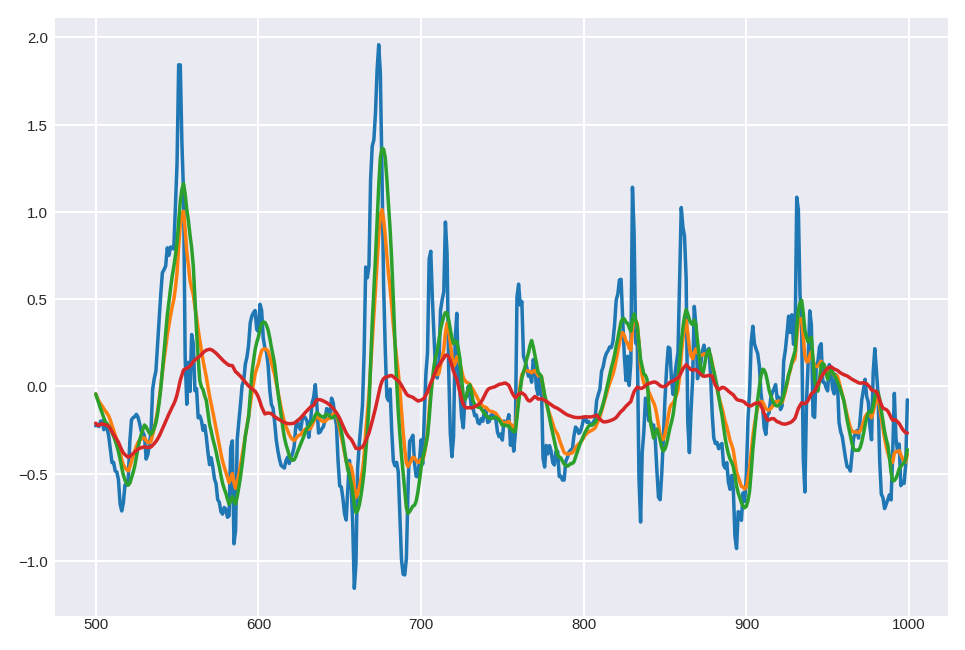

In [42]:
P.span=15
P.smoothing = "FFT+EMA"
# raw_dfList_exp1 = dfList_exp1
# raw_dfList_exp2 = dfList_exp2
P.cut_off_freq=42
ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2[0]['x_a'][500:1000].plot()
EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
EMAed_dfList_exp2[0]['x_a'][500:1000].plot()

dfList_exp1 = ffted_dfList_exp1
dfList_exp2 = ffted_dfList_exp2

dfList_exp1 =EMAed_dfList_exp1
dfList_exp2 =EMAed_dfList_exp2

SMAed_dfList_exp1 = get_SMAed_dfList(ffted_dfList_exp1, winsize=10)
SMAed_dfList_exp2 = get_SMAed_dfList(ffted_dfList_exp2, winsize=10)
SMAed_dfList_exp2[0]['x_a'][500:1000].plot()

raw_dfList_exp2[0]['x_a'][500:1000].rolling(window=50, min_periods=0).mean().plot()

In [43]:
randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
print(f"train_set: {train_set}\ntest_set: {test_set}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


Loading exp1 data:
47) accel_count: 22777, gyro_count: 22226
Loading exp2 data:
47) accel_count: 17718, gyro_count: 18353


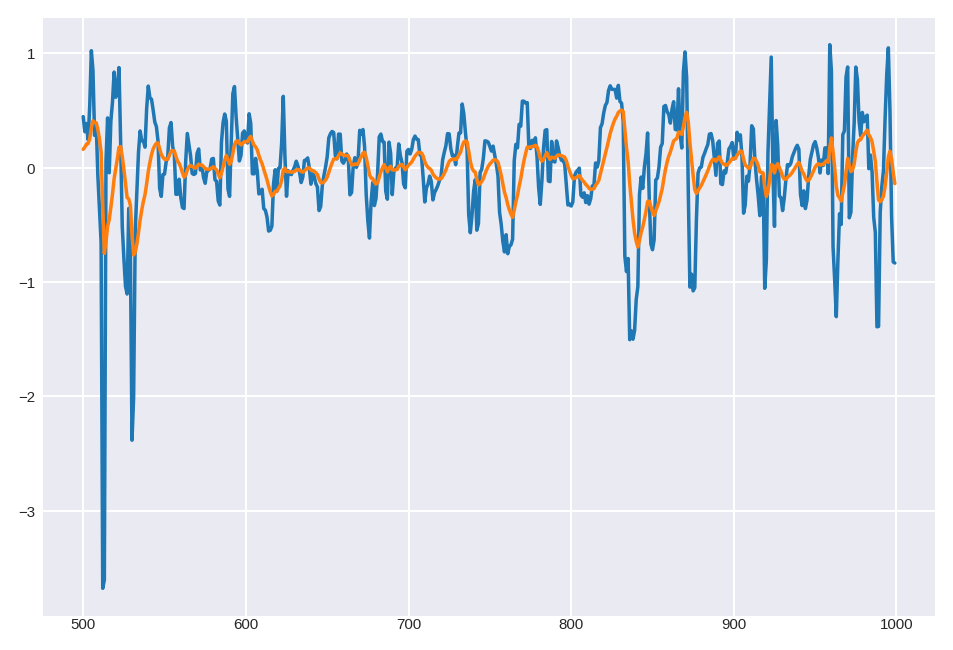

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
user_47_idx: 29
np.unique(all_user_set): [ 1  2  3  4  5  6  7  8 19 21 22 26 27 28 29 35 36 37 38 39 40 41 42 43
 44 45 46 48 49]
X_exp1_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
X_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
fitted_scaler_

In [44]:
num_sample_points_per_exp_user_47 = 18000
df_exps_dict_user_47 = load_data_frames([47], P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

raw_dfList_exp1_user_47 = dfList_exp1_user_47
raw_dfList_exp2_user_47 = dfList_exp2_user_47

ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47[0]['x_a'][500:1000].plot()

dfList_exp1_user_47 = ffted_dfList_exp1_user_47
dfList_exp2_user_47 = ffted_dfList_exp2_user_47

EMAed_dfList_exp1_user_47 = get_EMAed_dfList(ffted_dfList_exp1_user_47, span=P.span)
EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
EMAed_dfList_exp2_user_47[0]['x_a'][500:1000].plot()

dfList_exp1_user_47 = EMAed_dfList_exp1_user_47
dfList_exp2_user_47 = EMAed_dfList_exp2_user_47

%run ./utility-functions.ipynb


# preparing train data
X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.step_width, train_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, P.window_size, P.step_width, 
                                                                                                                    scaler=P.scaler, num_sample_points_per_exp=P.num_sample_points_per_exp, 
                                                                                                                    EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
                                                                                           X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, verbose=1)

print(f"len(exp1_df_train_dict): {len(X_train_exp1_dict)}")
print(f"len(exp2_df_train_dict): {len(X_train_exp2_dict)}")


# preparing test data
X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.step_width, test_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

print(f"len(X_test_exp1_dict): {len(X_test_exp1_dict)}")
print(f"len(X_test_exp2_dict): {len(X_test_exp2_dict)}")

In [45]:
import joblib
joblib.cpu_count()

32

In [54]:
P.Butter_per_win_argdict={
                        "filter_order": 10,
                        "cut_off_freq": 27,
                        "sampling_freq": 100,
                        "filtfilt": 1,
                        }
P.Butter_per_win_argdict=None
P.EMA_per_win_span=None
P.SMA_per_win_winsize=None
fitted_scaler_train_exp2_dict_user_47
fitted_scaler_train_exp2_dict


overlap=.5
window_size=2000
step_width = int(window_size * (1-overlap))
X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=\
get_raw_windows(dfList_exp1, dfList_exp2, window_size, step_width, train_set, P.scaler, P.num_sample_points_per_exp, 
                EMA_per_win_span=P.EMA_per_win_span, SMA_per_win_winsize=P.SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)

X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=\
get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, window_size, step_width, scaler=P.scaler, 
                        num_sample_points_per_exp=P.num_sample_points_per_exp, EMA_per_win_span=P.EMA_per_win_span,
                        SMA_per_win_winsize=P.SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)

X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
                                                                                           X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, verbose=1)

X_exp_train_dic = extract_WACA_features(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict)


len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
user_47_idx: 29
np.unique(all_user_set): [ 1  2  3  4  5  6  7  8 19 21 22 26 27 28 29 35 36 37 38 39 40 41 42 43
 44 45 46 48 49]
X_exp1_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
X_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
fitted_scaler_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
MakeWACAXExpDicOwner Time:  2.007819851860404
MakeWACAXExpDicUnknown Time:  6.557280275970697
Done extracting features


In [90]:
param_dist = {
    'model__n_neighbors': np.arange(5, 19),
    'model__contamination': np.linspace(0.001, 0.1, 50),
    #'metric': ['minkowski', 'manhattan', 'chebyshev', 'hamming', 'cosine']
}

P.LOF_metric="minkowski"

dfList_dict={"dfList_exp1": raw_dfList_exp1,
            "dfList_exp2": raw_dfList_exp2,
            "dfList_exp1_user_47": raw_dfList_exp1_user_47,
            "dfList_exp2_user_47": raw_dfList_exp2_user_47,}
EER_distro_df=calculate_EER_different_window_sizes_train_OCSVM_IF_LOF(dfList_dict, window_size_lst=[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000], train_set=train_set, exp_config=P, 
                                                                      extract_features_func=extract_WACA_features, overlap=.5, param_dist=param_dist)

  0%|          | 0/9 [00:00<?, ?it/s]

window_size: 125
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 337
len_exp2_user_47: 289
MakeWACAXExpDicOwner Time:  13.21212294884026
MakeWACAXExpDicUnknown Time:  69.44257257506251
Done extracting features



  0%|          | 0/3 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 9057.99it/s]

 33%|███▎      | 1/3 [00:45<01:30, 45.45s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 8433.30it/s]

 67%|██████▋   | 2/3 [01:30<00:45, 45.22s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 8354.36it/s]

100%|██████████| 3/3 [02:16<00:00, 45.60s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 24428.10it/s]

 20%|██        | 1/5 [00:06<00:24,  6.04s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 22489.57it/s]

 40%|████      | 2/5 [00:12<00:18,  6.12s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 14936.98it/s]

 60%|██████    | 3/5 [00:18<00:12,  6.18s/it]

run: 3: 100%|██████████| 20/20 [00:00<00:00, 7713.66it/s]

 80%|████████  | 4/5 [00:24<00:06,  6.27s/it]

run: 4: 100%|██████████| 20/20 [00:00<00:00, 14727.19it/s]

 11%|█         | 1/9 [04:12<33:42, 252.83s/it]

window_size: 250
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 167
len_exp2_user_47: 143
MakeWACAXExpDicOwner Time:  6.984918901696801
MakeWACAXExpDicUnknown Time:  36.17084851488471
Done extracting features



  0%|          | 0/3 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 16231.83it/s]

 33%|███▎      | 1/3 [00:18<00:37, 18.88s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 17299.67it/s]

 67%|██████▋   | 2/3 [00:37<00:18, 18.51s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 17288.97it/s]

100%|██████████| 3/3 [00:55<00:00, 18.48s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 17958.91it/s]

 20%|██        | 1/5 [00:03<00:13,  3.43s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 14918.39it/s]

 40%|████      | 2/5 [00:06<00:09,  3.23s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 9821.58it/s]

 60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

run: 3: 100%|██████████| 20/20 [00:00<00:00, 10623.87it/s]

 80%|████████  | 4/5 [00:12<00:03,  3.23s/it]

run: 4: 100%|██████████| 20/20 [00:00<00:00, 12303.62it/s]

 22%|██▏       | 2/9 [06:09<20:07, 172.57s/it]

window_size: 500
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 83
len_exp2_user_47: 71
MakeWACAXExpDicOwner Time:  4.14110410772264
MakeWACAXExpDicUnknown Time:  19.09444717131555
Done extracting features



  0%|          | 0/3 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 14673.09it/s]

 33%|███▎      | 1/3 [00:09<00:18,  9.33s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 11486.52it/s]

 67%|██████▋   | 2/3 [00:18<00:09,  9.43s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 11808.29it/s]

100%|██████████| 3/3 [00:28<00:00,  9.42s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 16800.74it/s]

 20%|██        | 1/5 [00:01<00:06,  1.54s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 9795.20it/s]

 40%|████      | 2/5 [00:03<00:04,  1.51s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 10128.72it/s]

 60%|██████    | 3/5 [00:04<00:02,  1.48s/it]

run: 3: 100%|██████████| 20/20 [00:00<00:00, 14921.04it/s]

 80%|████████  | 4/5 [00:05<00:01,  1.47s/it]

run: 4: 100%|██████████| 20/20 [00:00<00:00, 10109.19it/s]

 33%|███▎      | 3/9 [07:08<12:05, 120.95s/it]

window_size: 750
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 55
len_exp2_user_47: 47
MakeWACAXExpDicOwner Time:  2.8369077686220407
MakeWACAXExpDicUnknown Time:  13.497096309438348
Done extracting features



  0%|          | 0/3 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 16051.68it/s]

 33%|███▎      | 1/3 [00:07<00:14,  7.38s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 9914.44it/s]

 67%|██████▋   | 2/3 [00:14<00:07,  7.39s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 9662.07it/s]

100%|██████████| 3/3 [00:22<00:00,  7.42s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 18918.83it/s]

 20%|██        | 1/5 [00:01<00:04,  1.16s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 14172.34it/s]

 40%|████      | 2/5 [00:02<00:03,  1.21s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 10657.61it/s]

 60%|██████    | 3/5 [00:03<00:02,  1.15s/it]

run: 3: 100%|██████████| 20/20 [00:00<00:00, 13287.83it/s]

 80%|████████  | 4/5 [00:04<00:01,  1.13s/it]

run: 4: 100%|██████████| 20/20 [00:00<00:00, 16516.26it/s]

 44%|████▍     | 4/9 [07:53<07:35, 91.01s/it] 

window_size: 1000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 41
len_exp2_user_47: 35
MakeWACAXExpDicOwner Time:  2.5546516124159098
MakeWACAXExpDicUnknown Time:  10.793326141312718
Done extracting features



  0%|          | 0/3 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 16480.57it/s]

 33%|███▎      | 1/3 [00:06<00:13,  6.61s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 15111.89it/s]

 67%|██████▋   | 2/3 [00:13<00:06,  6.67s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 12440.47it/s]

100%|██████████| 3/3 [00:20<00:00,  6.68s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 18712.04it/s]

 20%|██        | 1/5 [00:01<00:04,  1.05s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 16030.21it/s]

 40%|████      | 2/5 [00:02<00:03,  1.02s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 12901.58it/s]

 60%|██████    | 3/5 [00:03<00:02,  1.01s/it]

run: 3: 100%|██████████| 20/20 [00:00<00:00, 15697.25it/s]

 80%|████████  | 4/5 [00:04<00:00,  1.00it/s]

run: 4: 100%|██████████| 20/20 [00:00<00:00, 11554.56it/s]

 56%|█████▌    | 5/9 [08:32<04:48, 72.22s/it]

window_size: 1250
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 32
len_exp2_user_47: 27
MakeWACAXExpDicOwner Time:  2.1820521634072065
MakeWACAXExpDicUnknown Time:  9.014064809307456
Done extracting features



  0%|          | 0/3 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 15598.01it/s]

 33%|███▎      | 1/3 [00:06<00:12,  6.17s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 13895.33it/s]

 67%|██████▋   | 2/3 [00:12<00:06,  6.12s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 14473.10it/s]

100%|██████████| 3/3 [00:18<00:00,  6.14s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 14359.14it/s]

 20%|██        | 1/5 [00:00<00:03,  1.05it/s]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 13591.39it/s]

 40%|████      | 2/5 [00:01<00:02,  1.02it/s]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 16800.74it/s]

 60%|██████    | 3/5 [00:02<00:01,  1.02it/s]

run: 3: 100%|██████████| 20/20 [00:00<00:00, 20722.85it/s]

 80%|████████  | 4/5 [00:03<00:00,  1.06it/s]

run: 4: 100%|██████████| 20/20 [00:00<00:00, 14167.55it/s]

 67%|██████▋   | 6/9 [09:07<02:58, 59.51s/it]

window_size: 1500
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 27
len_exp2_user_47: 23
MakeWACAXExpDicOwner Time:  2.175041425973177
MakeWACAXExpDicUnknown Time:  8.237871140241623
Done extracting features



  0%|          | 0/3 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 15836.53it/s]

 33%|███▎      | 1/3 [00:05<00:11,  5.87s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 15738.48it/s]

 67%|██████▋   | 2/3 [00:11<00:05,  5.93s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 12143.32it/s]

100%|██████████| 3/3 [00:17<00:00,  5.94s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 19427.07it/s]

 20%|██        | 1/5 [00:01<00:04,  1.01s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 25070.56it/s]

 40%|████      | 2/5 [00:01<00:02,  1.04it/s]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 13856.31it/s]

 60%|██████    | 3/5 [00:02<00:01,  1.08it/s]

run: 3: 100%|██████████| 20/20 [00:00<00:00, 15981.35it/s]

 80%|████████  | 4/5 [00:03<00:00,  1.13it/s]

run: 4: 100%|██████████| 20/20 [00:00<00:00, 13969.37it/s]

 78%|███████▊  | 7/9 [09:40<01:41, 50.88s/it]

window_size: 1750
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 23
len_exp2_user_47: 19
MakeWACAXExpDicOwner Time:  2.2261695191264153
MakeWACAXExpDicUnknown Time:  7.378088649362326
Done extracting features



  0%|          | 0/3 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 12574.74it/s]

 33%|███▎      | 1/3 [00:05<00:11,  5.68s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 19714.71it/s]

 67%|██████▋   | 2/3 [00:11<00:05,  5.72s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 23703.33it/s]

100%|██████████| 3/3 [00:17<00:00,  5.76s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 16703.72it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 13697.92it/s]

 40%|████      | 2/5 [00:01<00:02,  1.14it/s]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 15073.87it/s]

 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]

run: 3: 100%|██████████| 20/20 [00:00<00:00, 14655.15it/s]

 80%|████████  | 4/5 [00:03<00:00,  1.20it/s]

run: 4: 100%|██████████| 20/20 [00:00<00:00, 13080.63it/s]

 89%|████████▉ | 8/9 [10:12<00:44, 44.70s/it]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  2.3874668311327696
MakeWACAXExpDicUnknown Time:  7.122879955917597
Done extracting features



  0%|          | 0/3 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 14740.13it/s]

 33%|███▎      | 1/3 [00:05<00:11,  5.52s/it]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 15471.43it/s]

 67%|██████▋   | 2/3 [00:11<00:05,  5.57s/it]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 13628.93it/s]

100%|██████████| 3/3 [00:16<00:00,  5.59s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 23230.71it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

run: 1: 100%|██████████| 20/20 [00:00<00:00, 16042.47it/s]

 40%|████      | 2/5 [00:01<00:02,  1.11it/s]

run: 2: 100%|██████████| 20/20 [00:00<00:00, 14041.86it/s]

 60%|██████    | 3/5 [00:02<00:01,  1.17it/s]

run: 3: 100%|██████████| 20/20 [00:00<00:00, 17855.70it/s]

 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

run: 4: 100%|██████████| 20/20 [00:00<00:00, 11778.44it/s]

100%|██████████| 9/9 [10:42<00:00, 71.44s/it]


In [192]:
df = EER_distro_df.copy()


In [193]:
df.Mean_EER.mean()

0.11400188801060132

In [194]:
df=df.astype({"window_size": np.int64})
window_size_arr = df.window_size.values
window_size_arr

array([ 125,  250,  500,  750, 1000, 1250, 1500, 1750, 2000])

In [195]:
T_df=df.set_index("window_size").T
T_df["Mean"] = T_df.loc["Mean_EER", window_size_arr].mean()
T_df["Variance"] = T_df.loc["Mean_EER", window_size_arr].var()

T_df

window_size,125,250,500,750,1000,1250,1500,1750,2000,Mean,Variance
step_width,62,125,250,375,500,625,750,875,1000,0.114002,0.000851
Mean_EER,0.177987,0.143673,0.115568,0.100957,0.093517,0.088939,0.101901,0.09262,0.110855,0.114002,0.000851
median_n_neighbors,11,8,13,13,12,14,12,11,11,0.114002,0.000851
median_contamination,0.057571,0.055551,0.055551,0.057571,0.057571,0.055551,0.057571,0.055551,0.057571,0.114002,0.000851


In [196]:
T_df.columns

Index([125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 'Mean', 'Variance'], dtype='object', name='window_size')

In [197]:
T_df.loc["Mean_EER", window_size_arr].mean()

0.11400188801060132

In [198]:
# Define the multi-level column index
window_size_arr = [125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
columns = [('Window Size', col) if col in window_size_arr else ("", col) for col in T_df.columns]
multiindex_columns = pd.MultiIndex.from_tuples(columns)

multiindex_columns

MultiIndex([('Window Size',        125),
            ('Window Size',        250),
            ('Window Size',        500),
            ('Window Size',        750),
            ('Window Size',       1000),
            ('Window Size',       1250),
            ('Window Size',       1500),
            ('Window Size',       1750),
            ('Window Size',       2000),
            (           '',     'Mean'),
            (           '', 'Variance')],
           )

In [201]:
# Update the DataFrame columns with the multi-level column index
T_df.columns = multiindex_columns
T_df

Window Size                                          \
                             125       250       500       750      1000   
step_width                    62       125       250       375       500   
Mean_EER                0.177987  0.143673  0.115568  0.100957  0.093517   
median_n_neighbors            11         8        13        13        12   
median_contamination    0.057571  0.055551  0.055551  0.057571  0.057571   

                                                                        \
                          1250      1500      1750      2000      Mean   
step_width                 625       750       875      1000  0.114002   
Mean_EER              0.088939  0.101901   0.09262  0.110855  0.114002   
median_n_neighbors          14        12        11        11  0.114002   
median_contamination  0.055551  0.057571  0.055551  0.057571  0.114002   

                                
                      Variance  
step_width            0.000851  
Mean_EER              0.000851  
median_n_neighbors    0.000851  
median_contamination  0.000851

In [ ]:
X_vals_owner_idx['cv_splits'][2][1][55:]

In [ ]:
len(train_set)
np.logspace(-3, 3, 6)
# np.arange(0, 10, 10)
np.logspace(1, 1, num=10, dtype=np.int64)
np.linspace(0.001, 0.5, num=6)
X_exp_train_dic.keys()

In [ ]:
param_dist

In [62]:
np.logspace(1, 2.7, num=10, dtype=np.int64)
np.linspace(50, 200, num=10, dtype=np.int64)
np.linspace(0, 1, num=10, dtype=np.float64)
np.arange(0.1, 1.1, 0.1)
np.arange(0.01, 0.11, 0.01)
np.linspace(50, 200, num=10, dtype=np.int64)

P.ocsvm_kernel=None
P.classifier="LOF"
a = evaluate_owner_classifier_train_valid(7, X_exp_train_dic, SEED, run, param_dist, cores=1, exp_config=P, verbose=0) 
a

AttributeError: 'ExperimentParameters' object has no attribute 'LOF_metric'

In [ ]:
1

In [75]:
param_dist = {
    'model__n_neighbors': np.arange(1, 19),
    'model__contamination': np.linspace(0.01, 0.1, 50),
    #'metric': ['minkowski', 'manhattan', 'chebyshev', 'hamming', 'cosine']
}

P.metric="minkowski"


df_results = None  # Will be filled with randomsearch scores


# Don't need to loop over to find the best PCA.
for run in tqdm(range(3)):
        
    with parallel_backend('loky', n_jobs=-1):
        df_reports = Parallel(n_jobs=-1, verbose=100)(delayed(evaluate_owner_classifier_train_valid)(owner_key, X_exp_train_dic, SEED, run, param_dist, cores=1, exp_config=P, verbose=0) 
                                                      for owner_key in tqdm(
                                                          X_exp_train_dic.keys(),
                                                          desc=f"run: {run}",
                                                      ))
    df_results = pd.concat([df_results] + df_reports, sort=False, ignore_index=True)
    
df_results
#2000 win size
#100%|██████████| 3/3 [01:55<00:00, 38.45s/it] parallel CORES=-1
#100%|██████████| 3/3 [01:53<00:00, 37.92s/it] CORES=-1
#100%|██████████| 3/3 [00:49<00:00, 16.40s/it] parallel CORES=1

#250 win size
#100%|██████████| 3/3 [00:52<00:00, 17.46s/it] CORES=1
#100%|██████████| 3/3 [02:00<00:00, 40.21s/it]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 13886.12it/s]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:    5.0s remaining:   44.9s
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    5.1s remaining:   28.8s
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    5.1s remaining:   20.4s
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    5.1s remaining:   15.3s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    5.1s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:    5.2s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    5.2s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    5.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    5.3s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapse

 33%|███▎      | 1/3 [00:05<00:11,  5.67s/it]

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    5.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:    5.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    5.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.6s finished



run: 1: 100%|██████████| 20/20 [00:00<00:00, 14310.15it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:    5.0s remaining:   45.2s
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    5.0s remaining:   28.6s
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    5.1s remaining:   20.3s
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    5.1s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    5.1s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:    5.1s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    5.2s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    5.2s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    5.4s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    5.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  13 out of  20 | el

 67%|██████▋   | 2/3 [00:11<00:05,  5.62s/it]

[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    5.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    5.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:    5.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    5.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.6s finished



run: 2: 100%|██████████| 20/20 [00:00<00:00, 26230.79it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:    5.0s remaining:   44.7s
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    5.0s remaining:   28.3s
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    5.0s remaining:   20.1s
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    5.0s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    5.1s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:    5.2s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    5.2s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    5.3s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    5.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    5.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  13 out of  20 | el

100%|██████████| 3/3 [00:16<00:00,  5.63s/it]

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    5.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:    5.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    5.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.6s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,param_model__contamination,24_test_eer,8_test_eer,11_test_eer,13_test_eer,...,27_test_accuracy,5_test_accuracy,29_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,7_test_eer,7_test_accuracy
0,0.000914,0.000036,0.001873,0.000043,12,0.098163,0.000,0.000,0.00,0.000,...,1.00,1.000,1.0,1.000000,0.000000,1,7,0,NaN,NaN
1,0.000908,0.000028,0.001874,0.000023,12,0.041224,0.000,0.000,0.00,0.000,...,1.00,1.000,1.0,1.000000,0.000000,1,7,0,NaN,NaN
2,0.000900,0.000011,0.001853,0.000022,7,0.030204,0.000,0.000,0.00,0.000,...,1.00,1.000,1.0,1.000000,0.000000,1,7,0,NaN,NaN
3,0.000903,0.000010,0.001883,0.000027,14,0.039388,0.000,0.000,0.00,0.000,...,1.00,1.000,1.0,1.000000,0.000000,1,7,0,NaN,NaN
4,0.000902,0.000008,0.001863,0.000019,11,0.065102,0.000,0.000,0.00,0.000,...,1.00,1.000,1.0,1.000000,0.000000,1,7,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,0.000910,0.000010,0.001866,0.000017,13,0.030204,0.100,0.275,0.10,0.075,...,1.00,1.000,NaN,0.903947,0.074456,33,29,2,0.275,0.725
4796,0.000905,0.000009,0.001874,0.000019,15,0.09449,0.075,0.250,0.05,0.175,...,1.00,0.950,NaN,0.888158,0.073614,46,29,2,0.250,0.750
4797,0.000904,0.000011,0.001848,0.000017,7,0.083469,0.050,0.125,0.05,0.050,...,0.95,0.950,NaN,0.938158,0.028526,9,29,2,0.050,0.950
4798,0.000891,0.000011,0.001799,0.000018,2,0.041224,0.450,0.250,0.30,0.175,...,0.80,0.600,NaN,0.719737,0.119368,70,29,2,0.250,0.750


AttributeError: 'NoneType' object has no attribute 'param_model__n_estimators'

ERROR! Session/line number was not unique in database. History logging moved to new session 864


In [61]:
df_reports

NameError: name 'df_reports' is not defined

In [ ]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))


In [ ]:
pd.set_option('display.max_columns', None)
# df_results[df_results['run']==1 ].groupby('owner').head(40)[6*20:8*20]

In [ ]:
# len(df_results[(df_results.rank_test_eer == 1) & (df_results.rank_test_accuracy == 1)])
len(df_results[(df_results.rank_test_eer == 1)])

In [ ]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# df_results[(df_results.rank_test_eer == 1) & (df_results.rank_test_accuracy == 1)].groupby('owner').head(40)[:269]
df_results[(df_results.rank_test_eer == 1)].groupby('owner').head(232)

In [ ]:
1*19*3

In [ ]:
df_results[df_results["owner"] == 14].shape

In [ ]:
# df_results[df_results["owner"] == 14][ df_results["rank_test_eer"] == 1]

In [ ]:
display(
    df_results[df_results["rank_test_eer"] == 1]
    .sort_values("mean_test_eer")
    .head(30)
)

In [ ]:
# display(
#     df_results[df_results["rank_test_eer"] == 1][
#         [
#             "mean_fit_time",
#             "param_model__nu",
#             "param_model__gamma",
#             "mean_test_accuracy",
#             "std_test_accuracy",
#             "mean_test_eer",
#             "std_test_eer",
#         ]
#     ].describe()
# )



In [76]:
print(df_results.param_model__n_neighbors.unique())
print(df_results.param_model__contamination.unique())
print(P.median_n_neighbors, P.median_contamination)

[12 7 14 11 17 13 10 4 8 9 18 3 16 2 5 6 1 15]
[0.09816326530612245 0.04122448979591837 0.030204081632653063
 0.03938775510204082 0.06510204081632653 0.04489795918367347
 0.019183673469387756 0.02102040816326531 0.013673469387755103
 0.06142857142857144 0.02285714285714286 0.06326530612244897
 0.05591836734693878 0.06877551020408164 0.07428571428571429
 0.059591836734693884 0.046734693877551026 0.01183673469387755
 0.03571428571428572 0.037551020408163265 0.01 0.08714285714285715
 0.04857142857142858 0.07979591836734694 0.017346938775510204
 0.052244897959183675 0.1 0.03387755102040817 0.08346938775510204
 0.015510204081632653 0.0926530612244898 0.02469387755102041
 0.0963265306122449 0.026530612244897958 0.07244897959183674
 0.05775510204081633 0.09448979591836734 0.02836734693877551
 0.08530612244897959 0.06693877551020408 0.07612244897959183
 0.032040816326530615 0.04306122448979592 0.05040816326530613
 0.08163265306122448 0.07061224489795918 0.09081632653061225
 0.05408163265306123

In [77]:
utils_plot_randomsearch_results_LOF(df_results, n_top=1)

{'median_n_neighbors': 12.0,
 'median_contamination': 0.05591836734693878,
 'fig': None}

0, −0.20
1, −0.15
2, −0.10
3, −0.05
4, 0.00
['0.200', '0.150', '0.100', '0.050', '0.000']


(12, 0.05591836734693878)

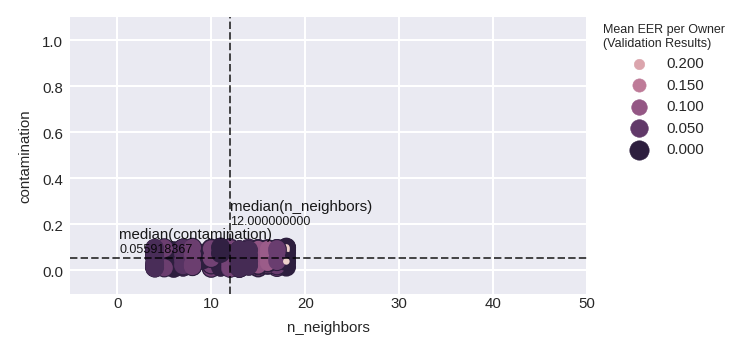

In [78]:
P.median_n_neighbors = None 
P.median_contamination = None
result_dict = utils_plot_randomsearch_results_LOF(df_results, n_top=1, plot=True)
P.median_n_neighbors, P.median_contamination=  result_dict["median_n_neighbors"], result_dict["median_contamination"]

P.median_n_neighbors = np.int64(np.round(P.median_n_neighbors))

P.median_n_neighbors, P.median_contamination

In [79]:
# _, _, _, _, fig = utils_plot_randomsearch_results_LOF(df_results, n_top=1)
# P.median_n_estimators, P.median_max_samples, P.median_contamination, P.median_max_features, fig = utils_plot_randomsearch_results_LOF(df_results[(df_results.rank_test_eer == 1) & (df_results.mean_test_eer < 0.5)], n_top=1)
# plt.savefig(f'WACA-LOF-Nu_Gamma_plot-win_size={P.window_size}-step_width={P.step_width}.png', bbox_inches='tight')
print(P.median_n_neighbors, P.median_contamination)

12 0.05591836734693878


In [ ]:
print(f"median_n_estimators: {P.median_n_estimators},  median_max_samples: {P.median_max_samples},  median_contamination: {P.median_contamination},  median_max_features: {P.median_max_features}")

In [ ]:
P.median_max_features=P.median_max_features*84
print(P.median_n_estimators, P.median_max_samples, P.median_contamination, P.median_max_features)

In [ ]:
utils_ppp(P)

In [ ]:
# evaluate_owner_LOF_train_test(2, X_exp_test_dic, SEED, run, param_dist, CORES=1)

In [ ]:
test_set
print(f"median_n_estimators: {P.median_n_estimators},  median_max_samples: {P.median_max_samples},  median_contamination: {P.median_contamination},  median_max_features: {P.median_max_features}")

In [ ]:
# param_dist
# P.median_n_estimators = 46 
# P.median_max_samples = 0.6
# P.median_contamination = 0.1
# P.median_max_features = 84

In [80]:
X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, window_size, step_width, test_set, P.scaler, P.num_sample_points_per_exp, 
                                                                                    EMA_per_win_span=P.EMA_per_win_span, SMA_per_win_winsize=P.SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)


X_exp_test_dic = extract_WACA_features(X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict)

len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  2.022051826119423
MakeWACAXExpDicUnknown Time:  3.172431232407689
Done extracting features


In [ ]:
test_set
# X_exp_test_dic

In [81]:
print(CORES)
# P.median_n_estimators=np.int64(P.median_n_estimators)
P.median_max_features=1.0

print(f"median_n_neighbors: {P.median_n_neighbors},  median_contamination: {P.median_contamination}")

-1
median_n_neighbors: 12,  median_contamination: 0.05591836734693878


In [82]:
test_df_results = None  # Will be filled with randomsearch scores
for run in tqdm(range(5)):

    with parallel_backend('loky', n_jobs=-1):
        df_score = Parallel(n_jobs=-1, verbose=100)(delayed(evaluate_owner_classifier_train_test)(owner_key, X_exp_test_dic, SEED, run, cores=2, exp_config=P, verbose=0) 
                                                           for owner_key in tqdm(X_exp_test_dic.keys(),
                                                                                 desc=f"run: {run}",
                                                                                ))
    test_df_results = pd.concat([test_df_results] + df_score, sort=False, ignore_index=True, axis=0)

run: 0: 100%|██████████| 10/10 [00:00<00:00, 50.40it/s][A


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


 20%|██        | 1/5 [00:01<00:06,  1.53s/it]

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.2s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished



run: 1: 100%|██████████| 10/10 [00:00<00:00, 9783.77it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.



 40%|████      | 2/5 [00:02<00:03,  1.03s/it]

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished



run: 2: 100%|██████████| 10/10 [00:00<00:00, 5282.50it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.



 60%|██████    | 3/5 [00:02<00:01,  1.13it/s]

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished



run: 3: 100%|██████████| 10/10 [00:00<00:00, 8013.57it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1733s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    0.3s remaining:    0.1s


 80%|████████  | 4/5 [00:03<00:00,  1.31it/s]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished



run: 4: 100%|██████████| 10/10 [00:00<00:00, 9400.05it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1400s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s



100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [83]:
test_df_results.head()
test_df_results.shape


(450, 10)

In [84]:
test_df_results

,fit_time,score_time,test_eer,test_accuracy,test_precision,test_recall,test_f1_score,owner,run,impostors
0,0.003341,0.012682,0.025,0.975,1.000000,0.95,0.974359,0,0,12
1,0.006234,0.019537,0.025,0.975,1.000000,0.95,0.974359,0,0,14
2,0.003746,0.015071,0.050,0.950,0.950000,0.95,0.950000,0,0,9
3,0.002230,0.017308,0.100,0.900,0.900000,0.90,0.900000,0,0,18
4,0.001342,0.015608,0.000,1.000,1.000000,1.00,1.000000,0,0,23
...,...,...,...,...,...,...,...,...,...,...
445,0.004809,0.014309,0.475,0.525,0.523810,0.55,0.536585,4,4,18
446,0.004636,0.017055,0.275,0.725,0.736842,0.70,0.717949,4,4,23
447,0.002233,0.014613,0.200,0.800,0.800000,0.80,0.800000,4,4,2
448,0.002070,0.014711,0.500,0.500,0.500000,0.55,0.523810,4,4,15


In [85]:
test_df_results.head()

,fit_time,score_time,test_eer,test_accuracy,test_precision,test_recall,test_f1_score,owner,run,impostors
0,0.003341,0.012682,0.025,0.975,1.00,0.95,0.974359,0,0,12
1,0.006234,0.019537,0.025,0.975,1.00,0.95,0.974359,0,0,14
2,0.003746,0.015071,0.050,0.950,0.95,0.95,0.950000,0,0,9
3,0.002230,0.017308,0.100,0.900,0.90,0.90,0.900000,0,0,18
4,0.001342,0.015608,0.000,1.000,1.00,1.00,1.000000,0,0,23


In [86]:
test_df_results.head()

,fit_time,score_time,test_eer,test_accuracy,test_precision,test_recall,test_f1_score,owner,run,impostors
0,0.003341,0.012682,0.025,0.975,1.00,0.95,0.974359,0,0,12
1,0.006234,0.019537,0.025,0.975,1.00,0.95,0.974359,0,0,14
2,0.003746,0.015071,0.050,0.950,0.95,0.95,0.950000,0,0,9
3,0.002230,0.017308,0.100,0.900,0.90,0.90,0.900000,0,0,18
4,0.001342,0.015608,0.000,1.000,1.00,1.00,1.000000,0,0,23


In [87]:
# mean_test_EER=test_df_results.groupby(['owner', 'impostors'], sort=False)[['fit_time', 'score_time', 'test_eer', 'train_eer', 'test_accuracy', 
#                                                                            'train_accuracy', 'test_precision', 'train_precision', 'test_recall',
#                                                                            'train_recall']].mean().reset_index()

mean_test_EER=test_df_results.groupby(['owner', 'impostors'], sort=False)[['fit_time', 'score_time', 'test_eer', 'test_accuracy', 
                                                                           'test_precision', 'test_recall', "test_f1_score"]].mean().reset_index()

mean_test_EER.test_eer.mean()

0.1636111111111111

In [88]:
test_df_plot = mean_test_EER.rename(
    columns={"test_f1_score": "Test F1_score","test_recall": "Test Recall" , "test_precision": "Test Precision", "test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "owner"}
).astype({"owner": str})
test_df_plot

,owner,impostors,fit_time,score_time,Test EER,Test Accuracy,Test Precision,Test Recall,Test F1_score
0,0,12,0.006888,0.019781,0.025,0.975,1.000000,0.95,0.974359
1,0,14,0.006710,0.019920,0.025,0.975,1.000000,0.95,0.974359
2,0,9,0.003850,0.017988,0.050,0.950,0.950000,0.95,0.950000
3,0,18,0.003314,0.018432,0.100,0.900,0.900000,0.90,0.900000
4,0,23,0.004119,0.017048,0.000,1.000,1.000000,1.00,1.000000
...,...,...,...,...,...,...,...,...,...
85,4,18,0.003764,0.015644,0.475,0.525,0.523810,0.55,0.536585
86,4,23,0.003348,0.017480,0.275,0.725,0.736842,0.70,0.717949
87,4,2,0.002671,0.016726,0.200,0.800,0.800000,0.80,0.800000
88,4,15,0.002109,0.016428,0.500,0.500,0.500000,0.55,0.523810


Overall mean: 0.1636
Overall mean: 0.8364
Overall mean: 0.8469
Overall mean: 0.8261
Overall mean: 0.8348


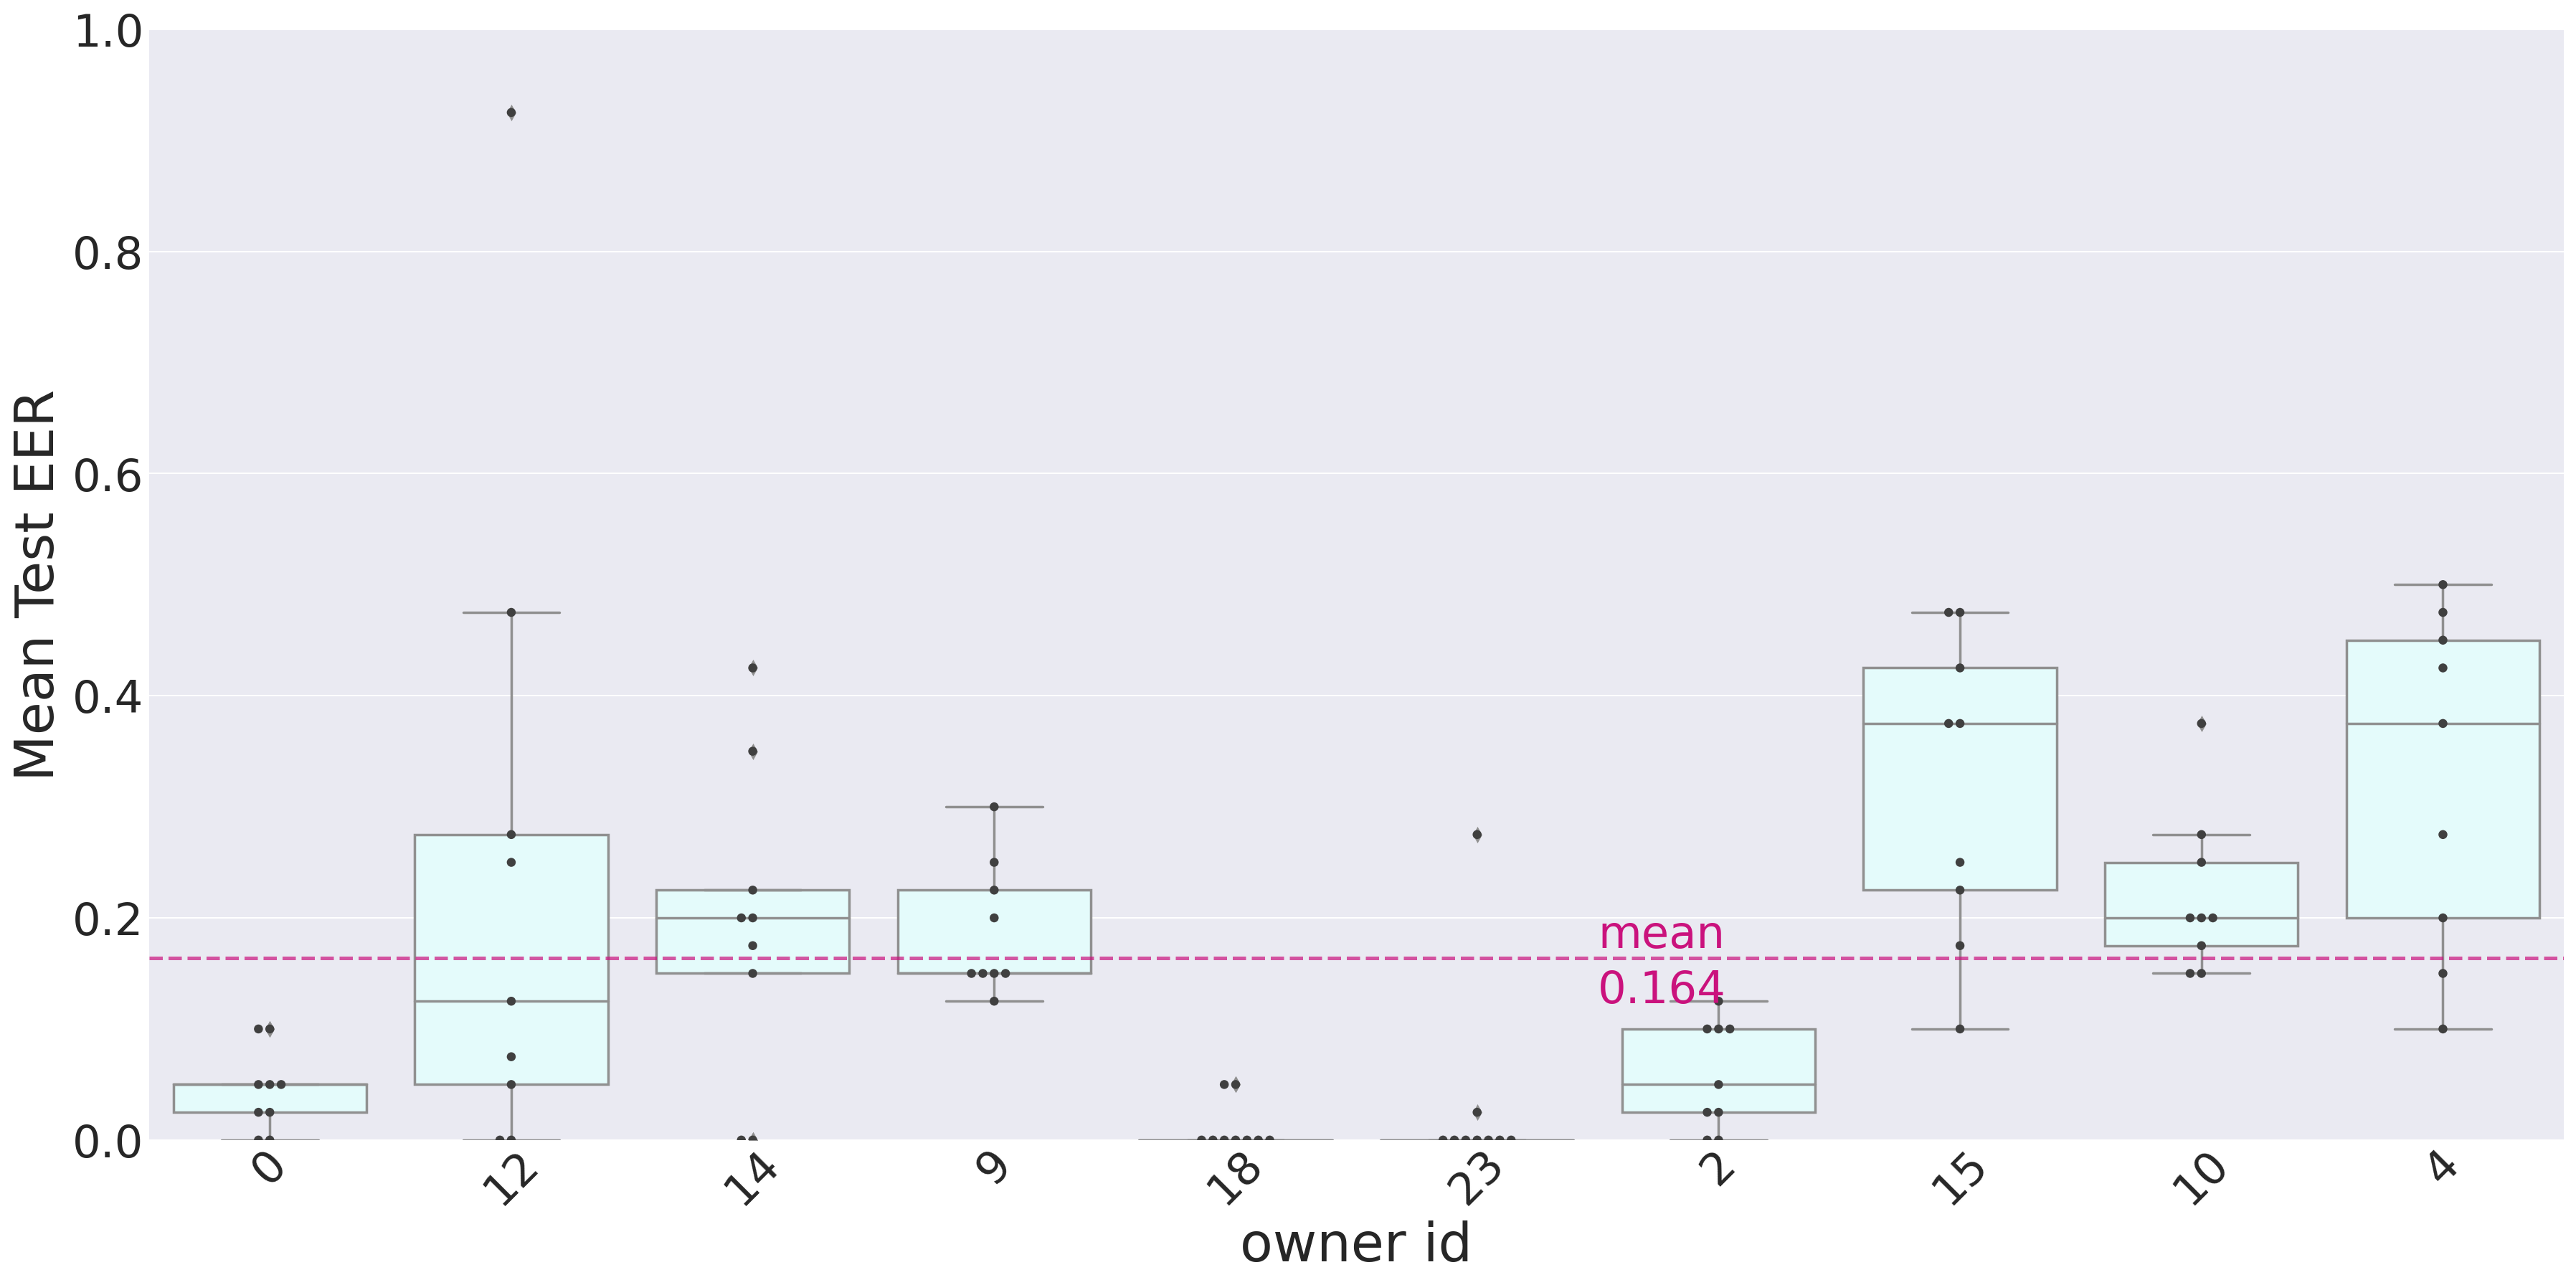

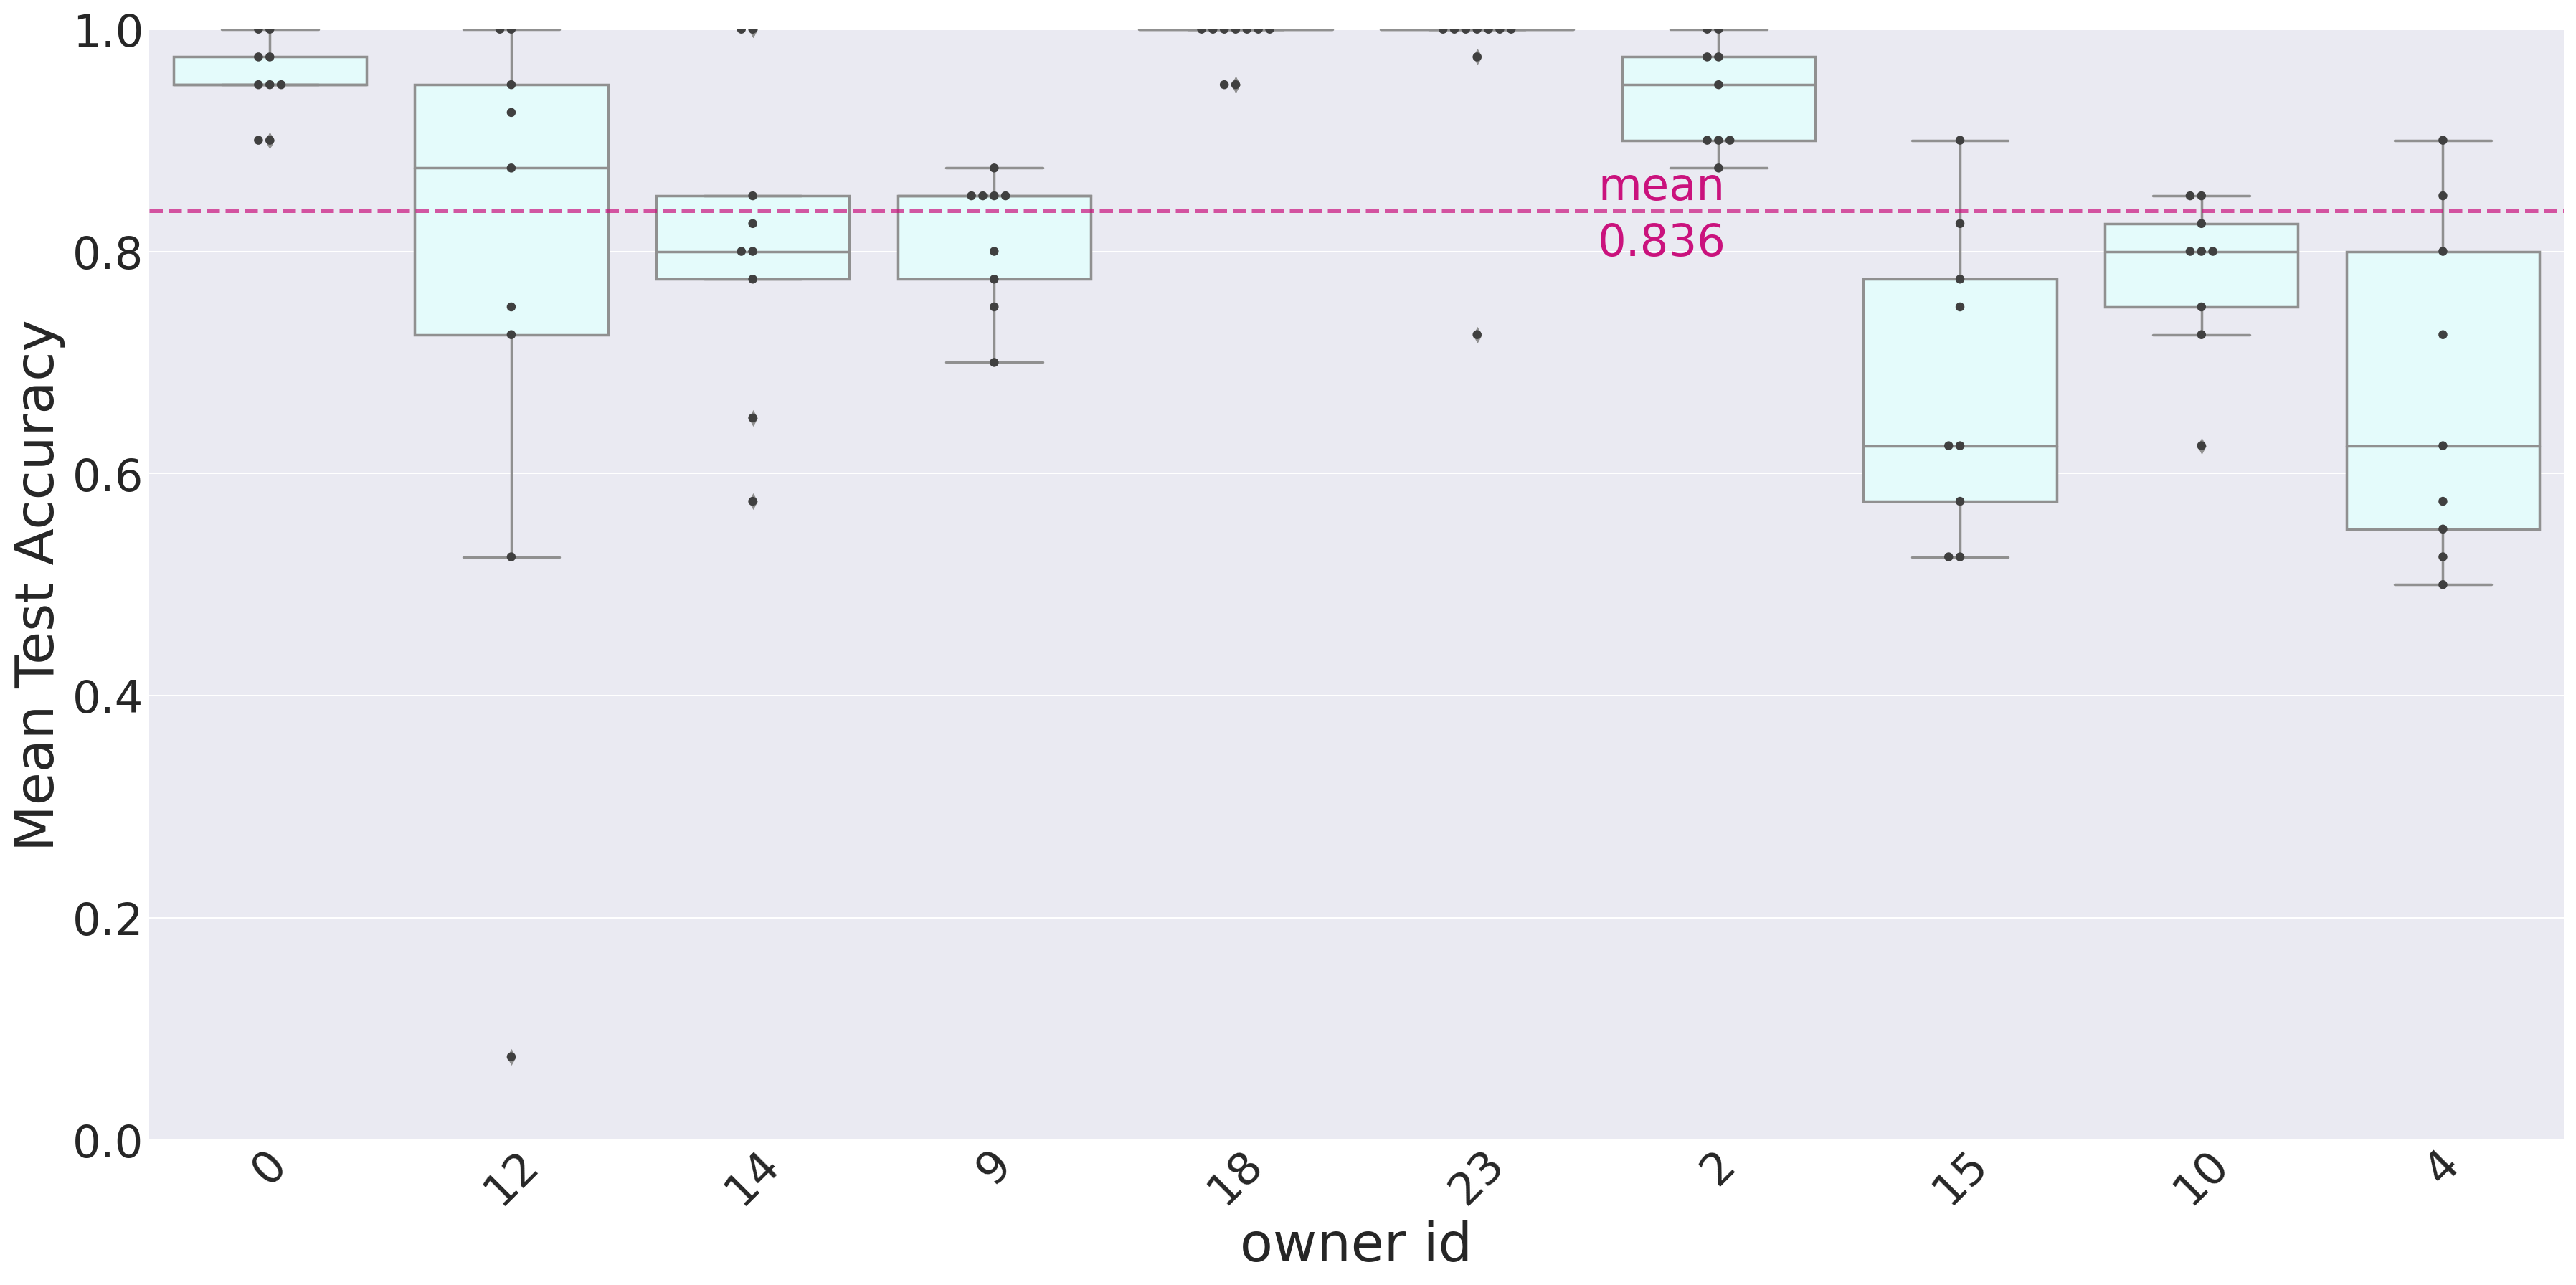

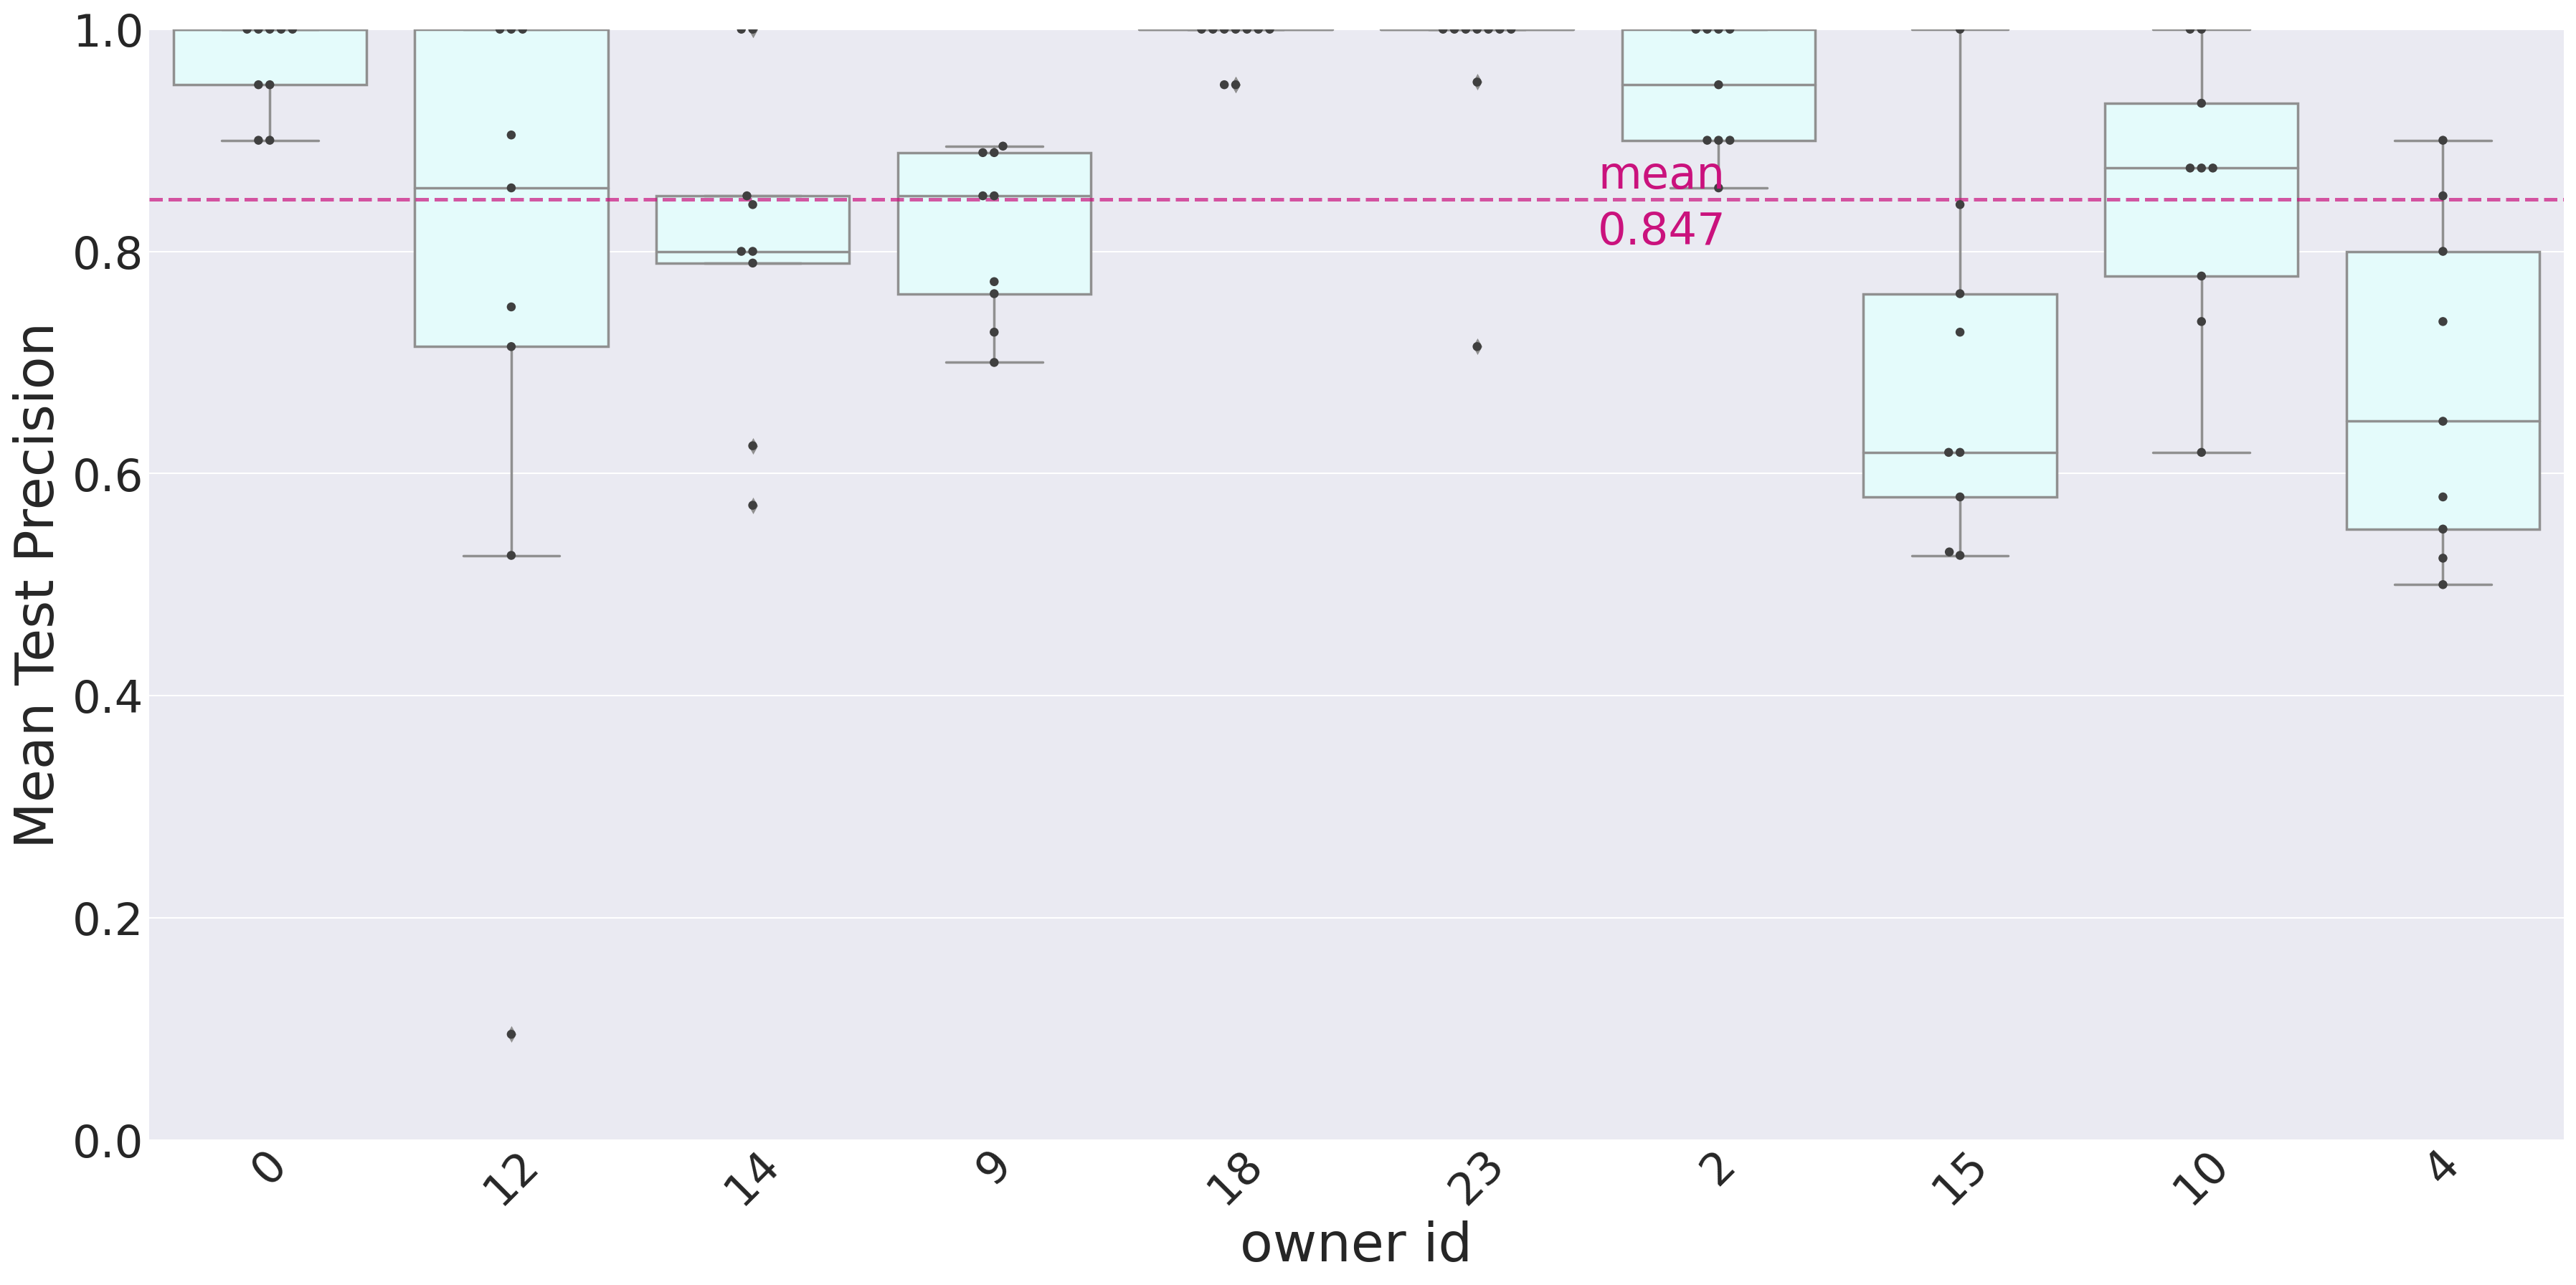

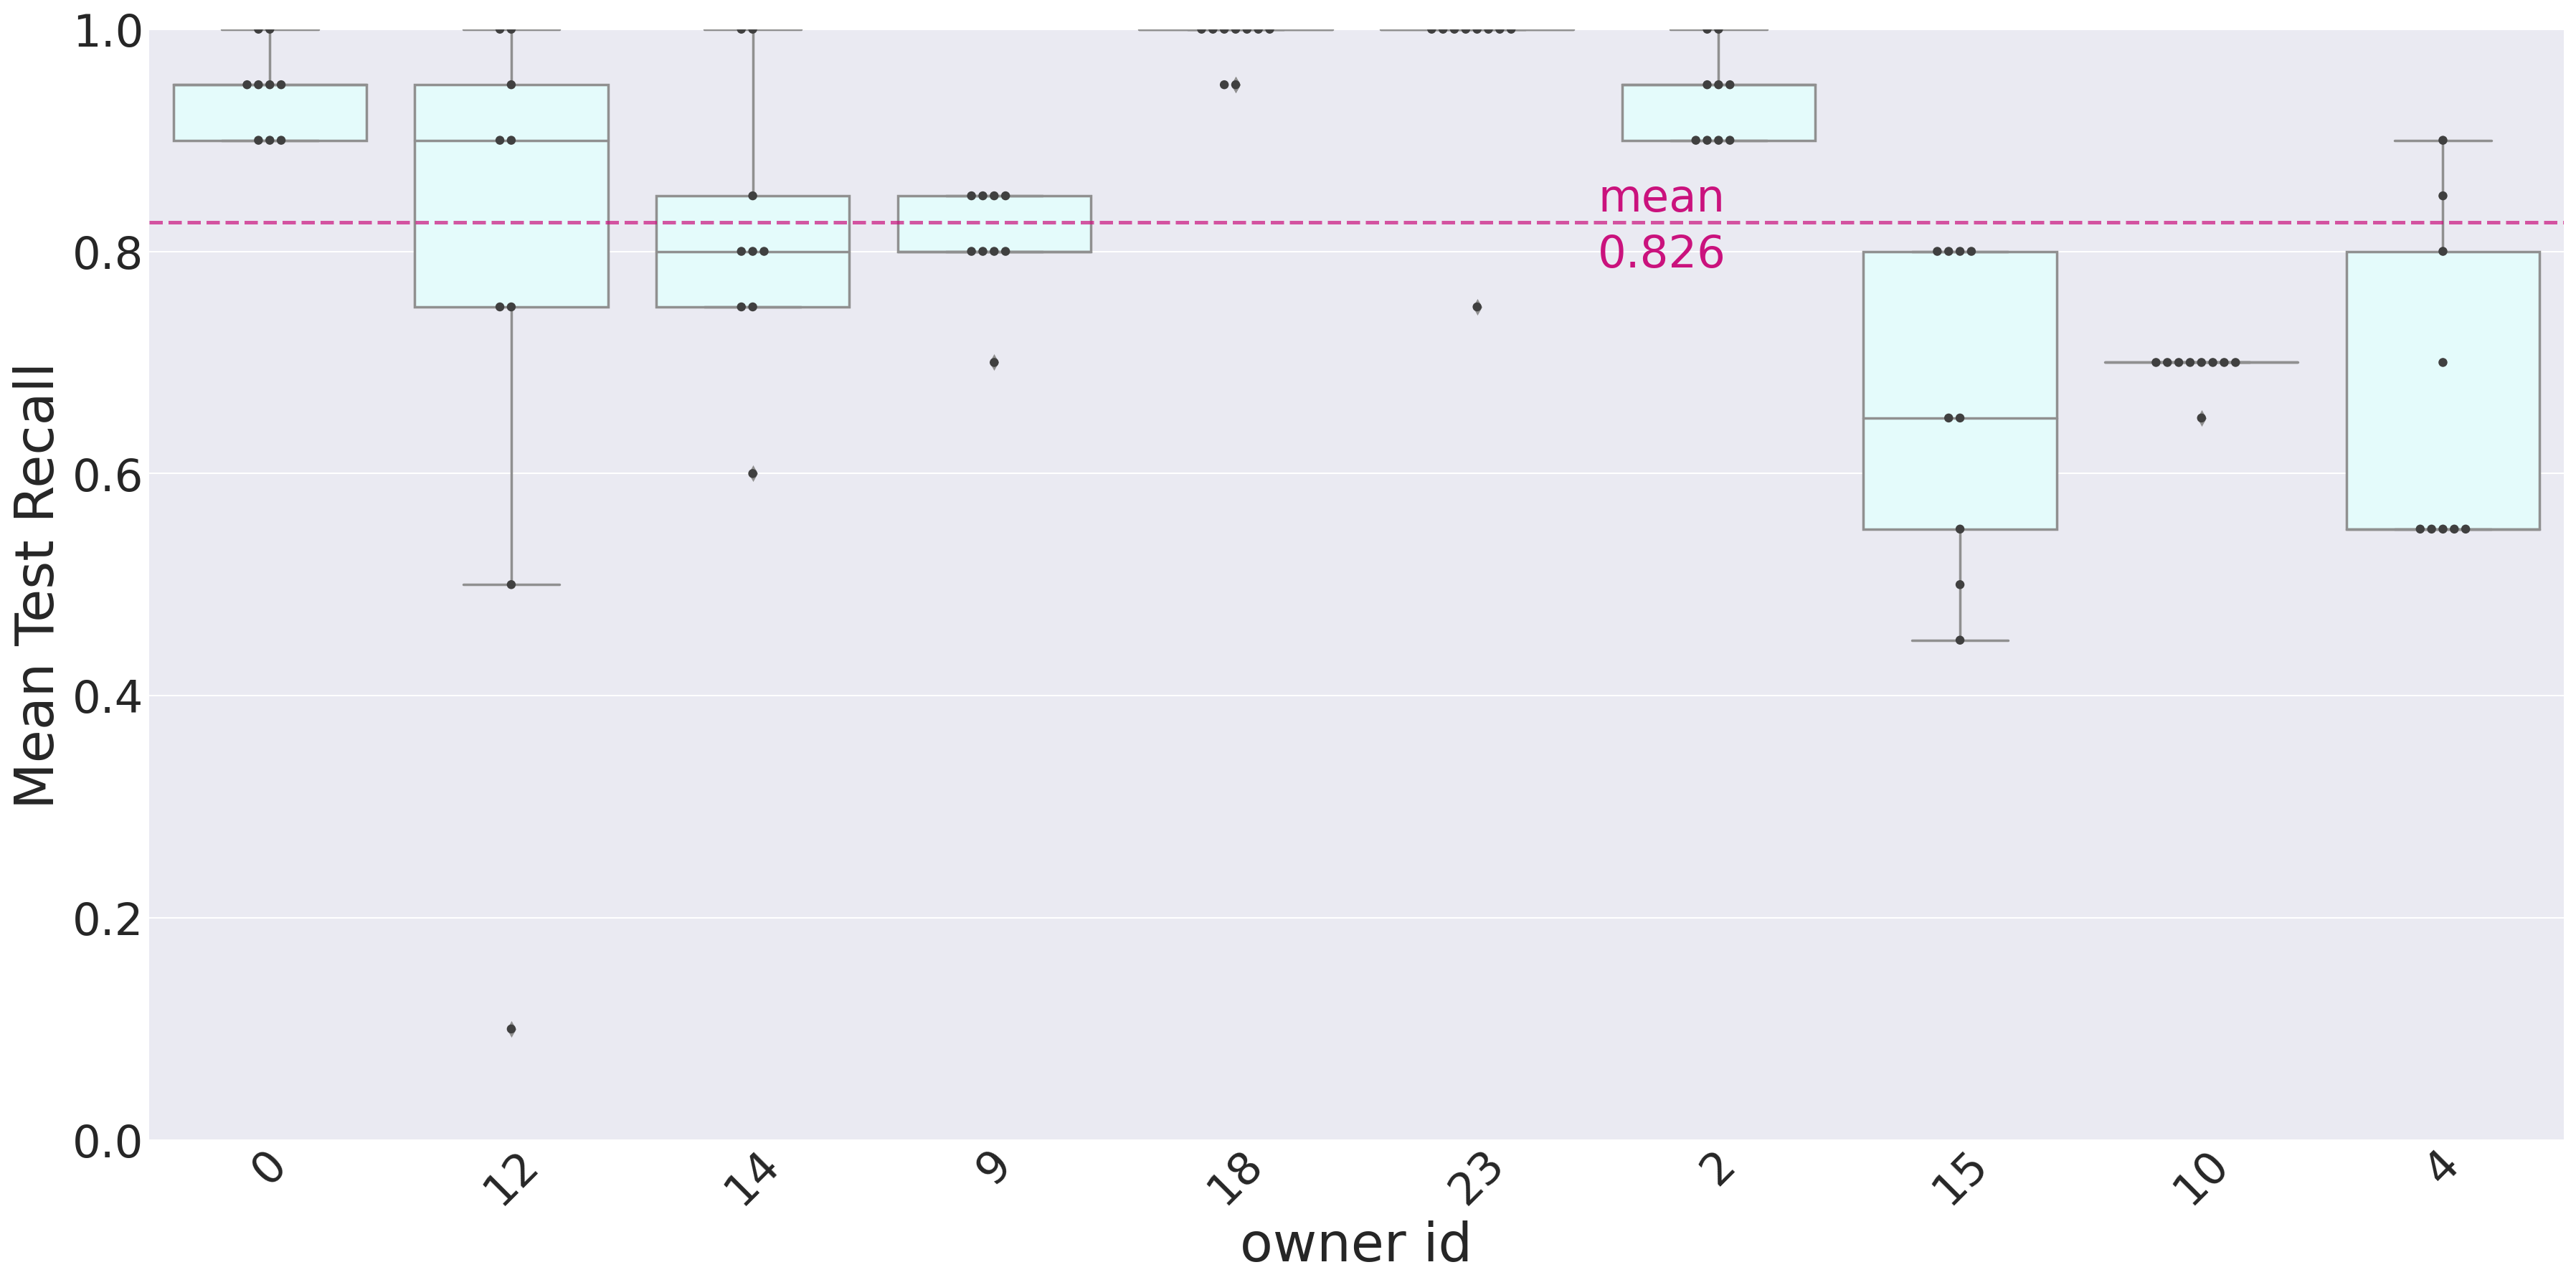

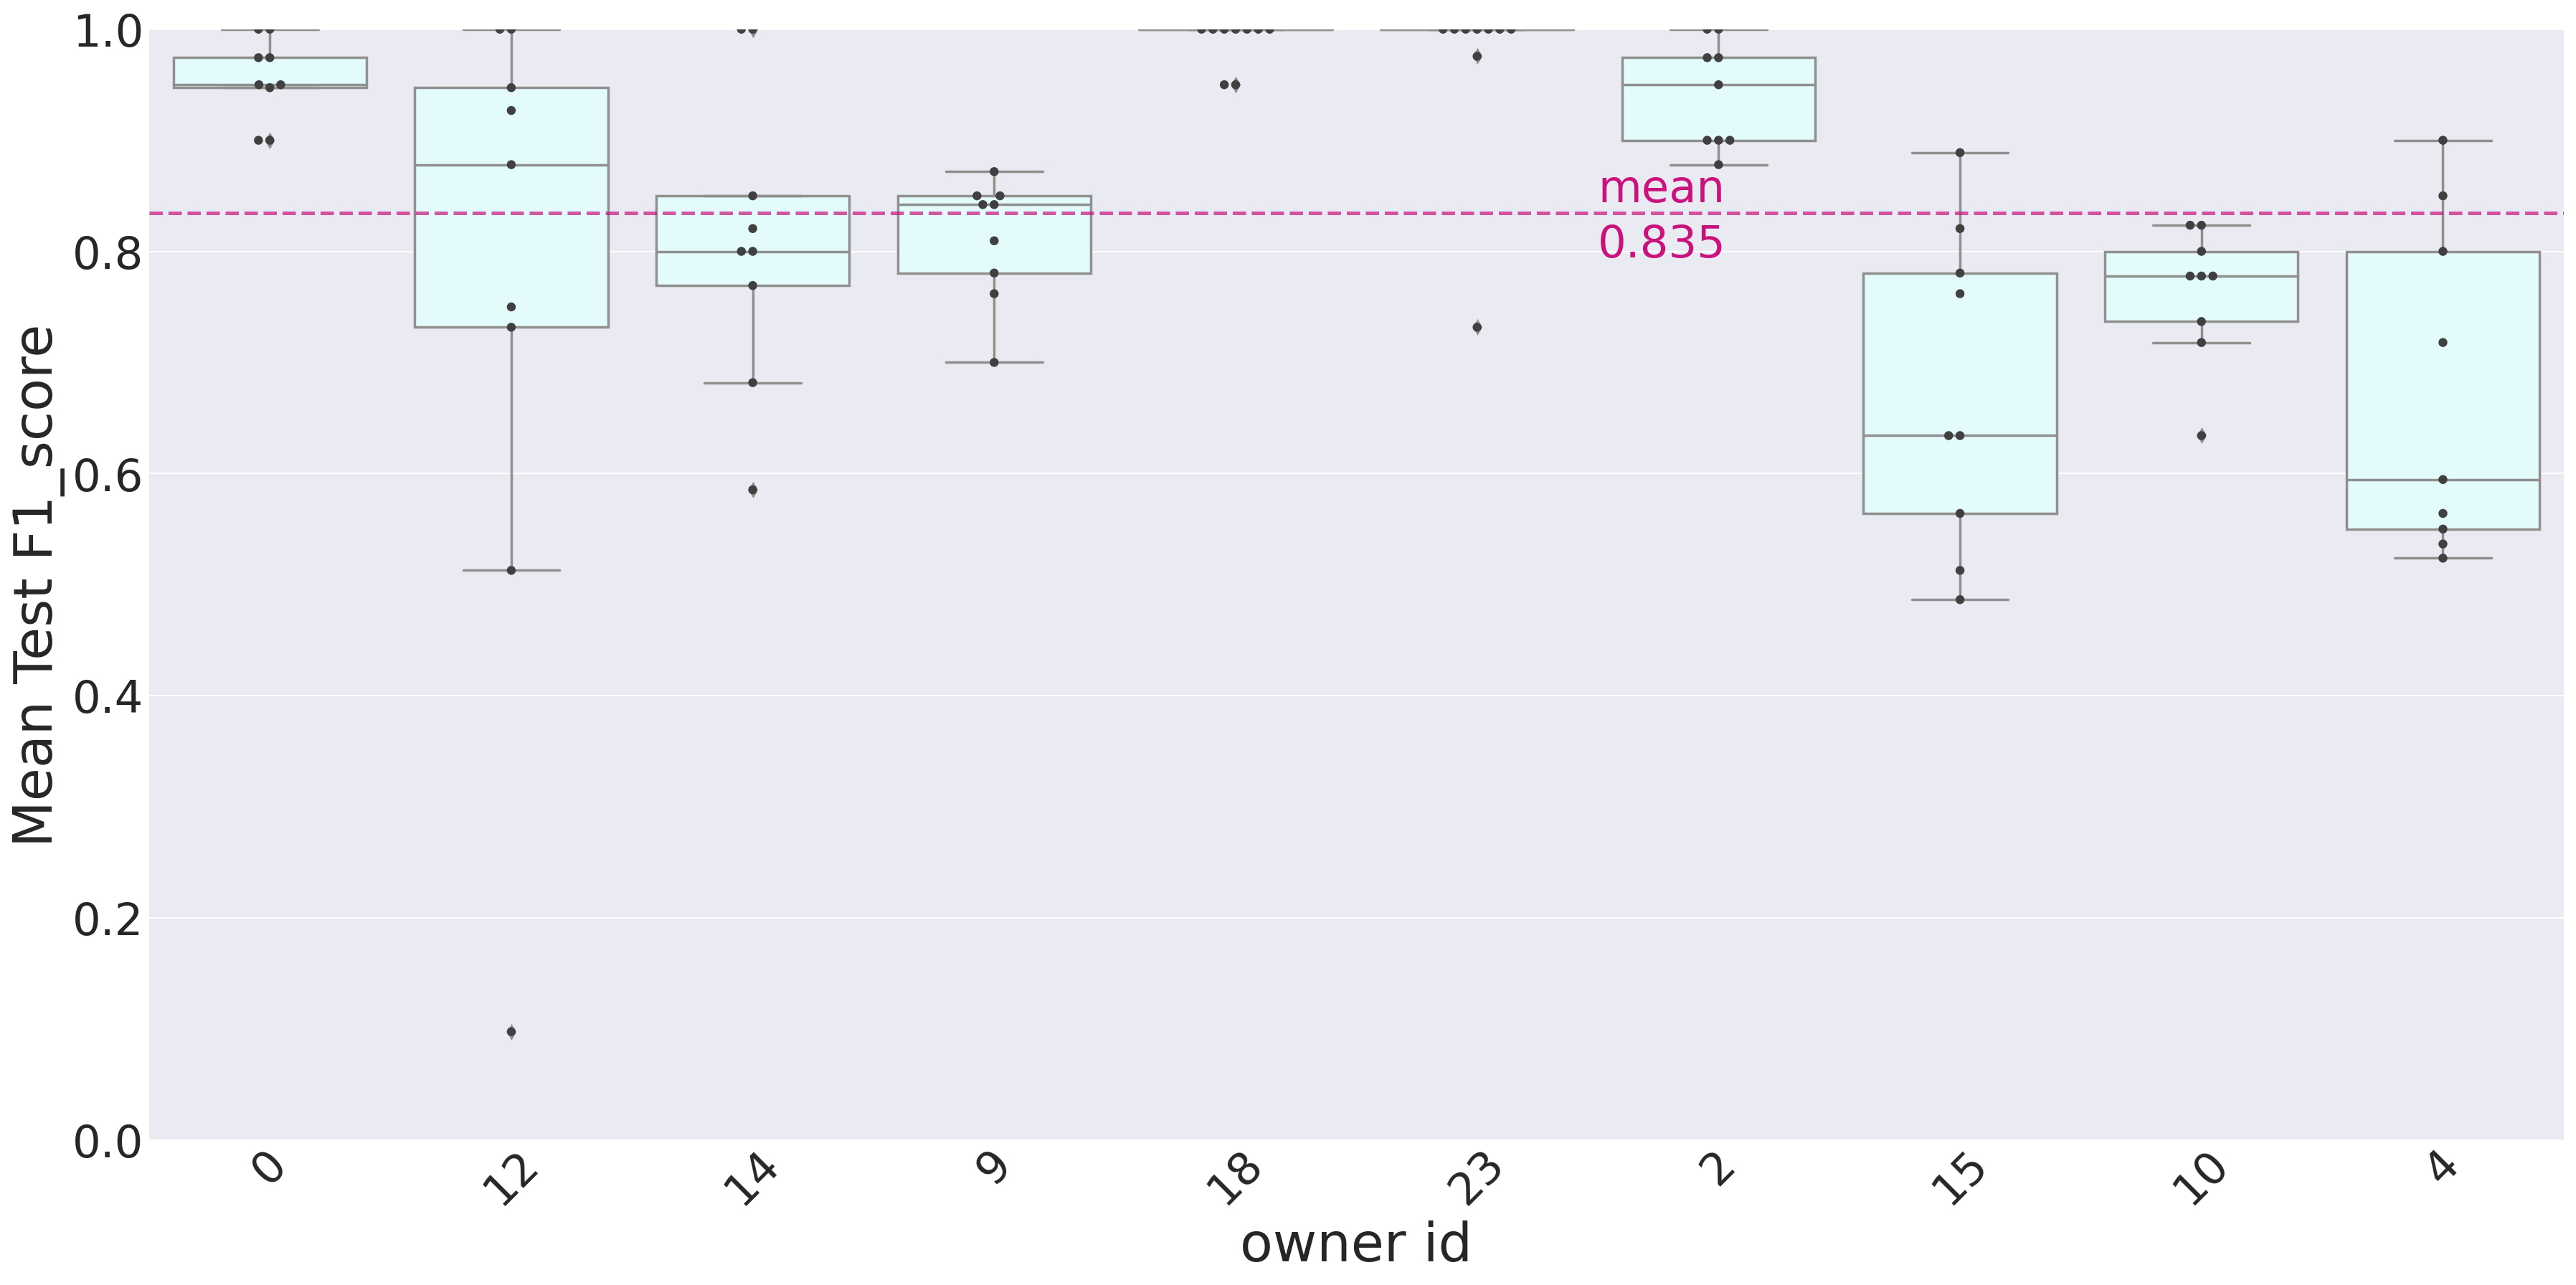

SEED: 567
--------------------SEED and CONSTANTS imported--------------------


In [89]:
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test EER', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_EER.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Accuracy', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Precision', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Recall', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test F1_score', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")

%run ./SEED-CONSTANTS.ipynb

In [ ]:
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test EER', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_EER.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Accuracy', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")

In [ ]:
print(gini(test_df_plot['Test EER'].to_numpy()))
lorenz_curve(test_df_plot['Test EER'].to_numpy())